In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import re
import konlpy
from nltk import download
import nltk
from nltk.tokenize import RegexpTokenizer
from PIL import Image
from wordcloud import WordCloud
from collections import Counter
import itertools

In [2]:
df = pd.read_excel('./원본데이터/0119_0126.xlsx')
df

,내용
0,한국의 데이트 문화는 미국인들이 익숙한 데이트 문화와는 조금 다르다. 많은 한국 젊...
1,한국은 다양한 맛있는 음식으로 유명하기에 수많은 한국 조리법들이 입소문을 탄 것도 ...
2,올해 오스카상 최종 후보 선정 불발로 가장 큰 화제에 오른 것은 박찬욱 감독의 “헤...
3,지난 일요일은 음력설이자 호랑이 해가 마무리되는 날이었다. 올해는 토끼 해에 해당한...
4,이달 초 밀라노에서 열린 프라다의 남성복 쇼 바깥 거리는 비명을 지르는 팬들로 가득...
...,...
100,방탄소년단 진 5개월 기초군사훈련 마쳤다\n \n “재밌게 잘 생활하고 있다”라고 ...
101,한류는 전 세계에 퍼져 있다. 한국 가요와 드라마에 이어 요즘 세계에서 한국어가 급...
102,뭄바이 거리에서 온라인 생중계 중 성추행을 당해 화제를 모은 한국 유튜버 박효정이 ...
103,ㅇ 문승현 주태국 대사는 주태국 대한민국대사관과 한국문화원이 방콕 홀리데이인 호텔에...


In [3]:
# director_df = df[df['내용'].str.contains('감독')]
# director_df = director_df.reset_index(drop=True)
# director_df

In [4]:
# w = list(director_df['내용'])
# for i in range(len(w)):
#     w[i] = str(w[i])
# content = ' '.join(w)
# content

### 한국어

In [5]:
from konlpy.tag import Komoran
kor_stopwords = ['한국', '한국의']

komoran = konlpy.tag.Komoran()

In [6]:
kor_total = []
for news in df['내용']:
    temp = []
    news = news.replace('.', '').replace(',','').replace("'","").replace('·', ' ').replace('=','').replace('\n','').replace('\t','').replace('\r','')
    pos_news = [t for t in komoran.nouns(news)]
    for i in range(len(pos_news)):
        if pos_news[i] not in kor_stopwords:
            temp.append(pos_news[i])
    kor_total.append(' '.join(temp))

In [7]:
#TfidfVectorizer

from sklearn.feature_extraction.text import TfidfVectorizer
kor_vectorizer = TfidfVectorizer()
kor_tfidf = kor_vectorizer.fit_transform(kor_total)

In [8]:
kor_tfidf_weights = [(word, kor_tfidf.getcol(idx).sum()) for word, idx in kor_vectorizer.vocabulary_.items()]
kor_tfidf_weights[0:10]

[('데이트', 0.40800321200585704),
 ('문화', 3.4459408350989755),
 ('미국인', 0.7066621329138212),
 ('젊은이들', 0.5681135574644287),
 ('서구', 0.2690507083619562),
 ('대부분', 0.7730248452489508),
 ('매너', 0.09557582983033998),
 ('한국인', 2.001383062373752),
 ('기본', 0.21376933743759818),
 ('에티켓', 0.04778791491516999)]

### 영어

In [9]:
eng_stopwords = ['The', 'the', 'korean', 'Korean','korea','Korea','kore','Kore','top','TOP']
eng_total = []

# 3글자 이상
tokenizer = RegexpTokenizer("[\w']{3,}")

In [10]:
for news in df['내용']:
    temp = []
    news = news.replace('.', '').replace(',','').replace("'","").replace('·', ' ').replace('=','')
    news = re.sub('[^a-zA-Z ]', '', news).strip()
    pos_news = [t for t in tokenizer.tokenize(news)]
    for i in range(len(pos_news)):
        if pos_news[i] not in eng_stopwords:
            temp.append(''.join(pos_news[i]))
    eng_total.append(' '.join(temp))
print(eng_total[104])

Experience games traditions for Lunar New Year KCC Business World Taguig City


In [11]:
# TfidfVectorizer
eng_vectorizer = TfidfVectorizer()
eng_tfidf = eng_vectorizer.fit_transform(eng_total)

In [12]:
eng_tfidf_weights = [(word, eng_tfidf.getcol(idx).sum()) for word, idx in eng_vectorizer.vocabulary_.items()]
eng_tfidf_weights[0:10]

[('bts', 4.141564610622058),
 ('sns', 2.378602842764591),
 ('launchmetrics', 0.43931356604999783),
 ('alison', 0.43931356604999783),
 ('bring', 0.43931356604999783),
 ('karla', 0.30379752538675453),
 ('otto', 0.30379752538675453),
 ('lefty', 0.43931356604999783),
 ('american', 0.7538766733729496),
 ('food', 0.7538766733729496)]

### 한국어 + 영어 데이터프레임으로 합치기

In [13]:
kor_df = pd.DataFrame(kor_tfidf_weights, columns = ['word', 'tfidf'])
eng_df = pd.DataFrame(eng_tfidf_weights, columns = ['word', 'tfidf'])

In [14]:
final = pd.concat([kor_df, eng_df], axis=0)
final = final.sort_values('tfidf', ascending=False)
final = final.reset_index(drop=True)
final

,word,tfidf
0,kpop,6.315406
1,bts,4.141565
2,설날,3.673217
3,드라마,3.609193
4,문화,3.445941
...,...,...
5036,지점,0.025228
5037,우드,0.025228
5038,발리,0.025228
5039,규율,0.025228


In [15]:
final = final.head(100)
final_dict = final.set_index('word').to_dict()['tfidf']
final_dict

{'kpop': 6.315405798852915,
 'bts': 4.141564610622058,
 '설날': 3.6732170961444868,
 '드라마': 3.6091926613178997,
 '문화': 3.4459408350989755,
 '전통': 3.4359714208886607,
 '음식': 3.2190377703427564,
 '영화': 3.2079473974394705,
 '새해': 3.0205868494908206,
 '사람': 2.9657075839307403,
 '태국': 2.5103408705739323,
 '세계': 2.488164140609282,
 '인도': 2.4240362798200703,
 'sns': 2.378602842764591,
 '그룹': 2.348554051590413,
 '떡국': 2.309848510869716,
 '행사': 2.249902231874077,
 '가족': 2.220300337041414,
 '기념': 2.125804558633818,
 '한국어': 2.1127129362174006,
 '브랜드': 2.0390605240625503,
 '인기': 2.011651425511725,
 '한국인': 2.001383062373752,
 '시작': 1.8586496473289005,
 '1월': 1.8464035437878585,
 '교수': 1.8105721495252287,
 '중국': 1.7857366435489412,
 '명절': 1.7852670410203058,
 '방탄소년단': 1.759415716901929,
 '요리': 1.7384278250929643,
 '필리핀': 1.7087808564899123,
 '음력': 1.6859552820232955,
 '넷플릭스': 1.6713279976994628,
 '때문': 1.6554951198219277,
 '올해': 1.6323747685494978,
 '사용': 1.6080349726872454,
 '시간': 1.559886065170834,


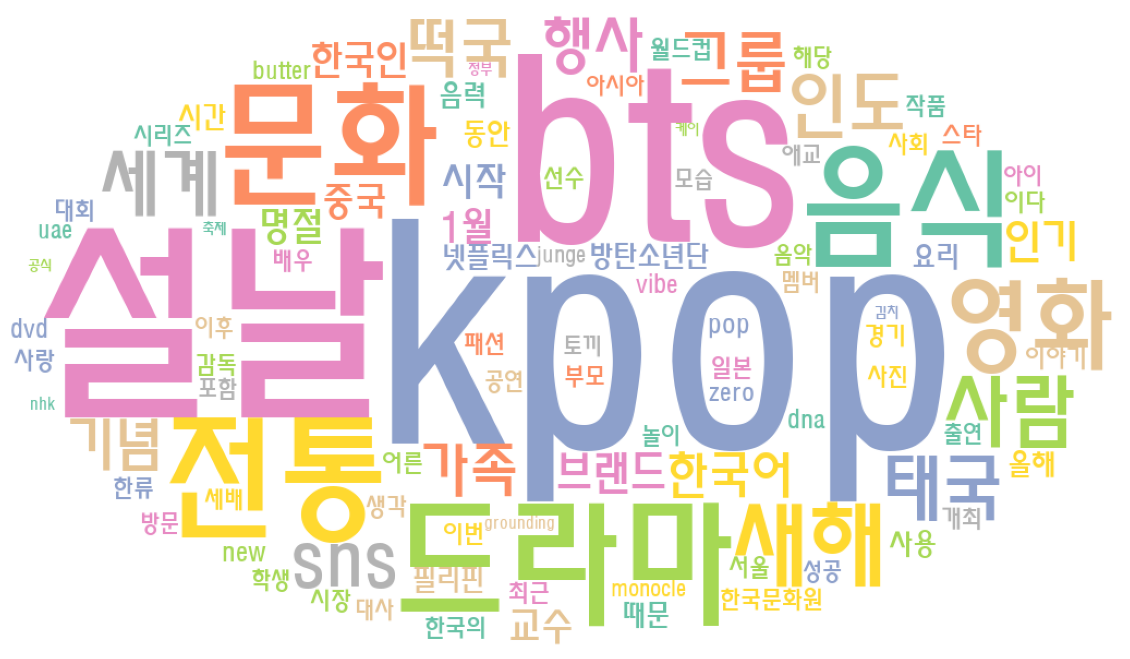

In [16]:
im = Image.open('mask.png') # 이미지 파일 읽어오기
mask_arr = np.array(im) # 픽셀 값 배열 형태 변환

sns.set_style('white')
font_path = 'C:\Windows\Fonts\HMFMMUEX.TTC'

#prefer_horizontal=Ture -> 글씨 똑바르게 나오게 하기
wc = WordCloud(font_path=font_path, width=1500, height=1200, background_color='white', colormap='Set2', mask=mask_arr, prefer_horizontal=True).fit_words(final_dict)

plt.figure(figsize = (20, 20))  
plt.imshow(wc)
plt.axis('off')
plt.show()

In [17]:
# End of File